In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import models,layers

In [21]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=5

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Datasets",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
total_dataset = len(dataset)*BATCH_SIZE
total_dataset

16032

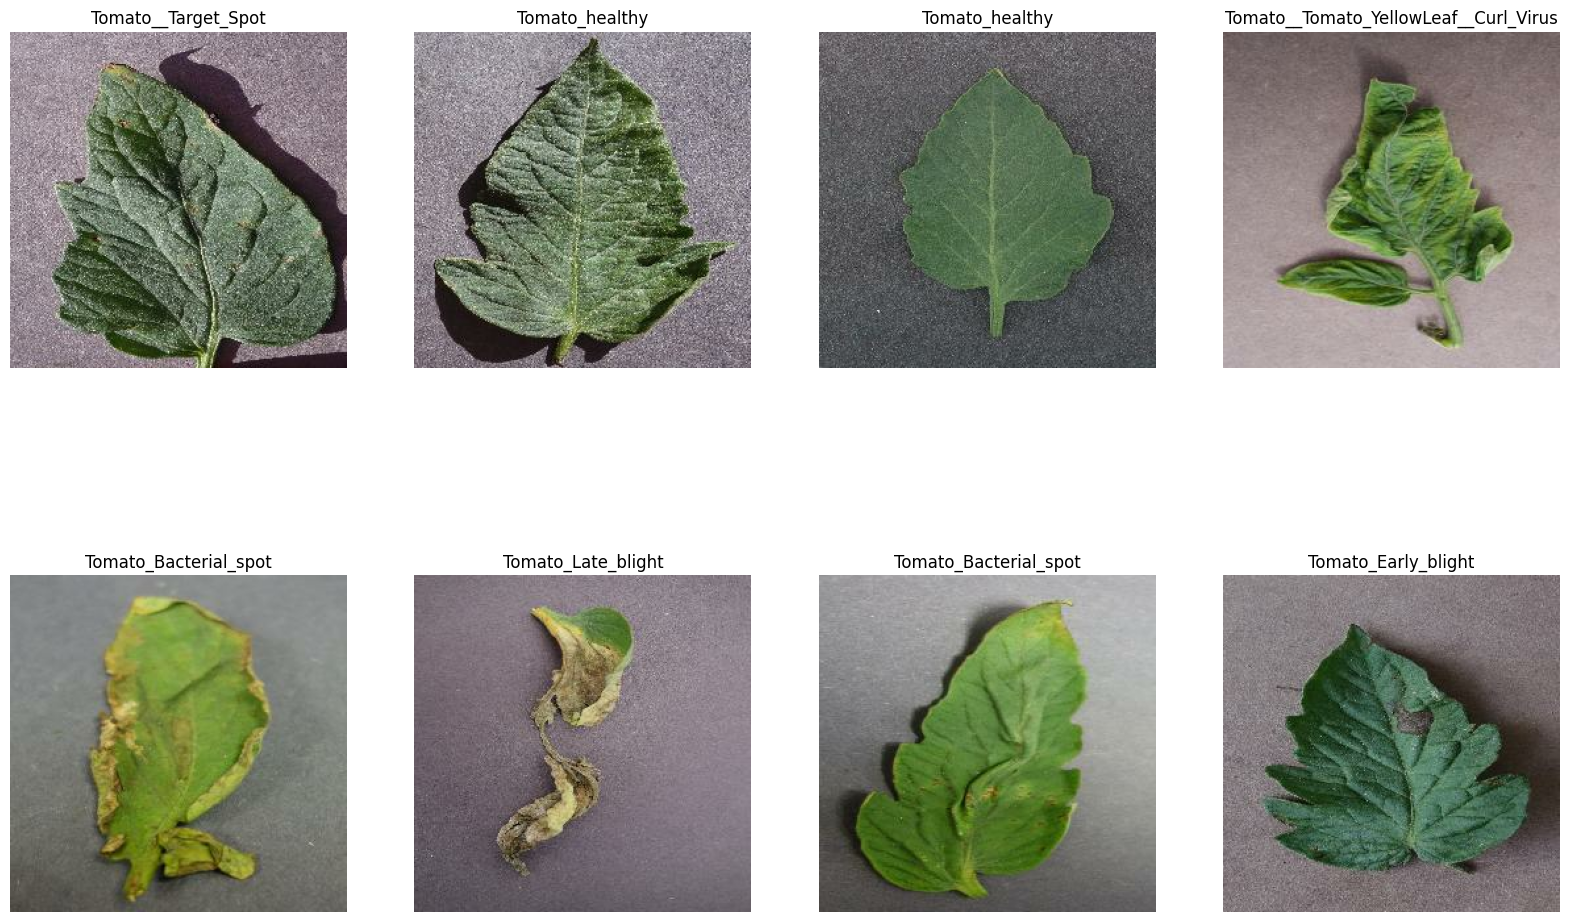

In [6]:
plt.figure(figsize=(20,20))
for image_batch, label_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        
        

In [7]:
def get_dataset_split(ds, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)
    
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_split(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(4,4),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax") 
])

model.build(input_shape = input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 253, 253, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2  (32, 126, 126, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 124, 124, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [16]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [22]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/5
400/400 [==============================] - 796s 2s/step - loss: 0.4620 - accuracy: 0.8368 - val_loss: 1.0960 - val_accuracy: 0.7275
Epoch 2/5
400/400 [==============================] - 743s 2s/step - loss: 0.4068 - accuracy: 0.8573 - val_loss: 0.5765 - val_accuracy: 0.8069
Epoch 3/5
400/400 [==============================] - 768s 2s/step - loss: 0.3487 - accuracy: 0.8748 - val_loss: 1.5251 - val_accuracy: 0.6350
Epoch 4/5
400/400 [==============================] - 989s 2s/step - loss: 0.3040 - accuracy: 0.8924 - val_loss: 0.5399 - val_accuracy: 0.8062
Epoch 5/5
400/400 [==============================] - 793s 2s/step - loss: 0.2826 - accuracy: 0.9019 - val_loss: 0.4626 - val_accuracy: 0.8519


In [23]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 54s 406ms/step - loss: 0.3826 - accuracy: 0.8740


Text(0.5, 1.0, 'Training and Validation Loss')

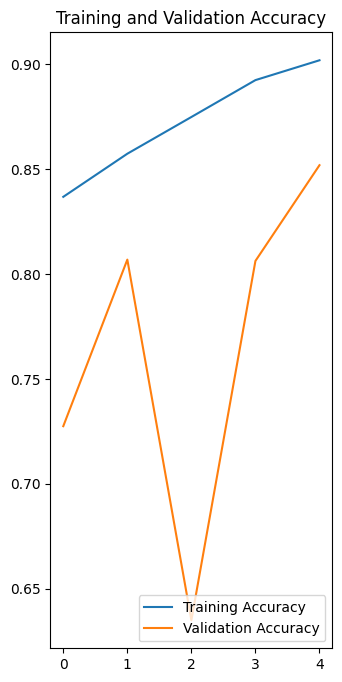

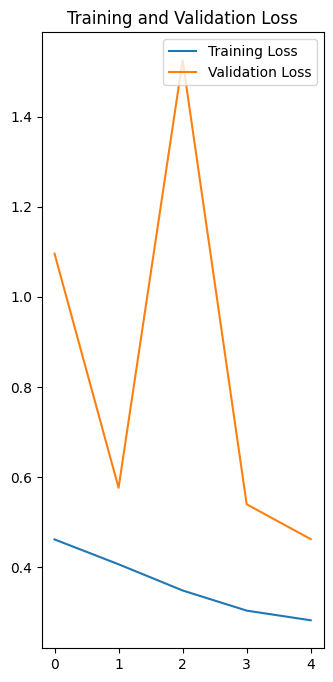

In [26]:
acc= history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

First image to predict
actual label: Tomato_Bacterial_spot
1/1 [==============================] - 1s 772ms/step
predicted label: Tomato_Bacterial_spot


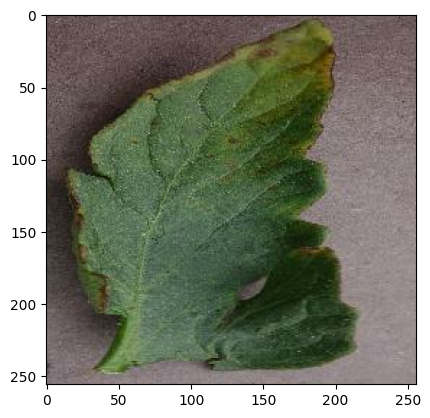

In [27]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [31]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    # This code will create a batch
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 29ms/step


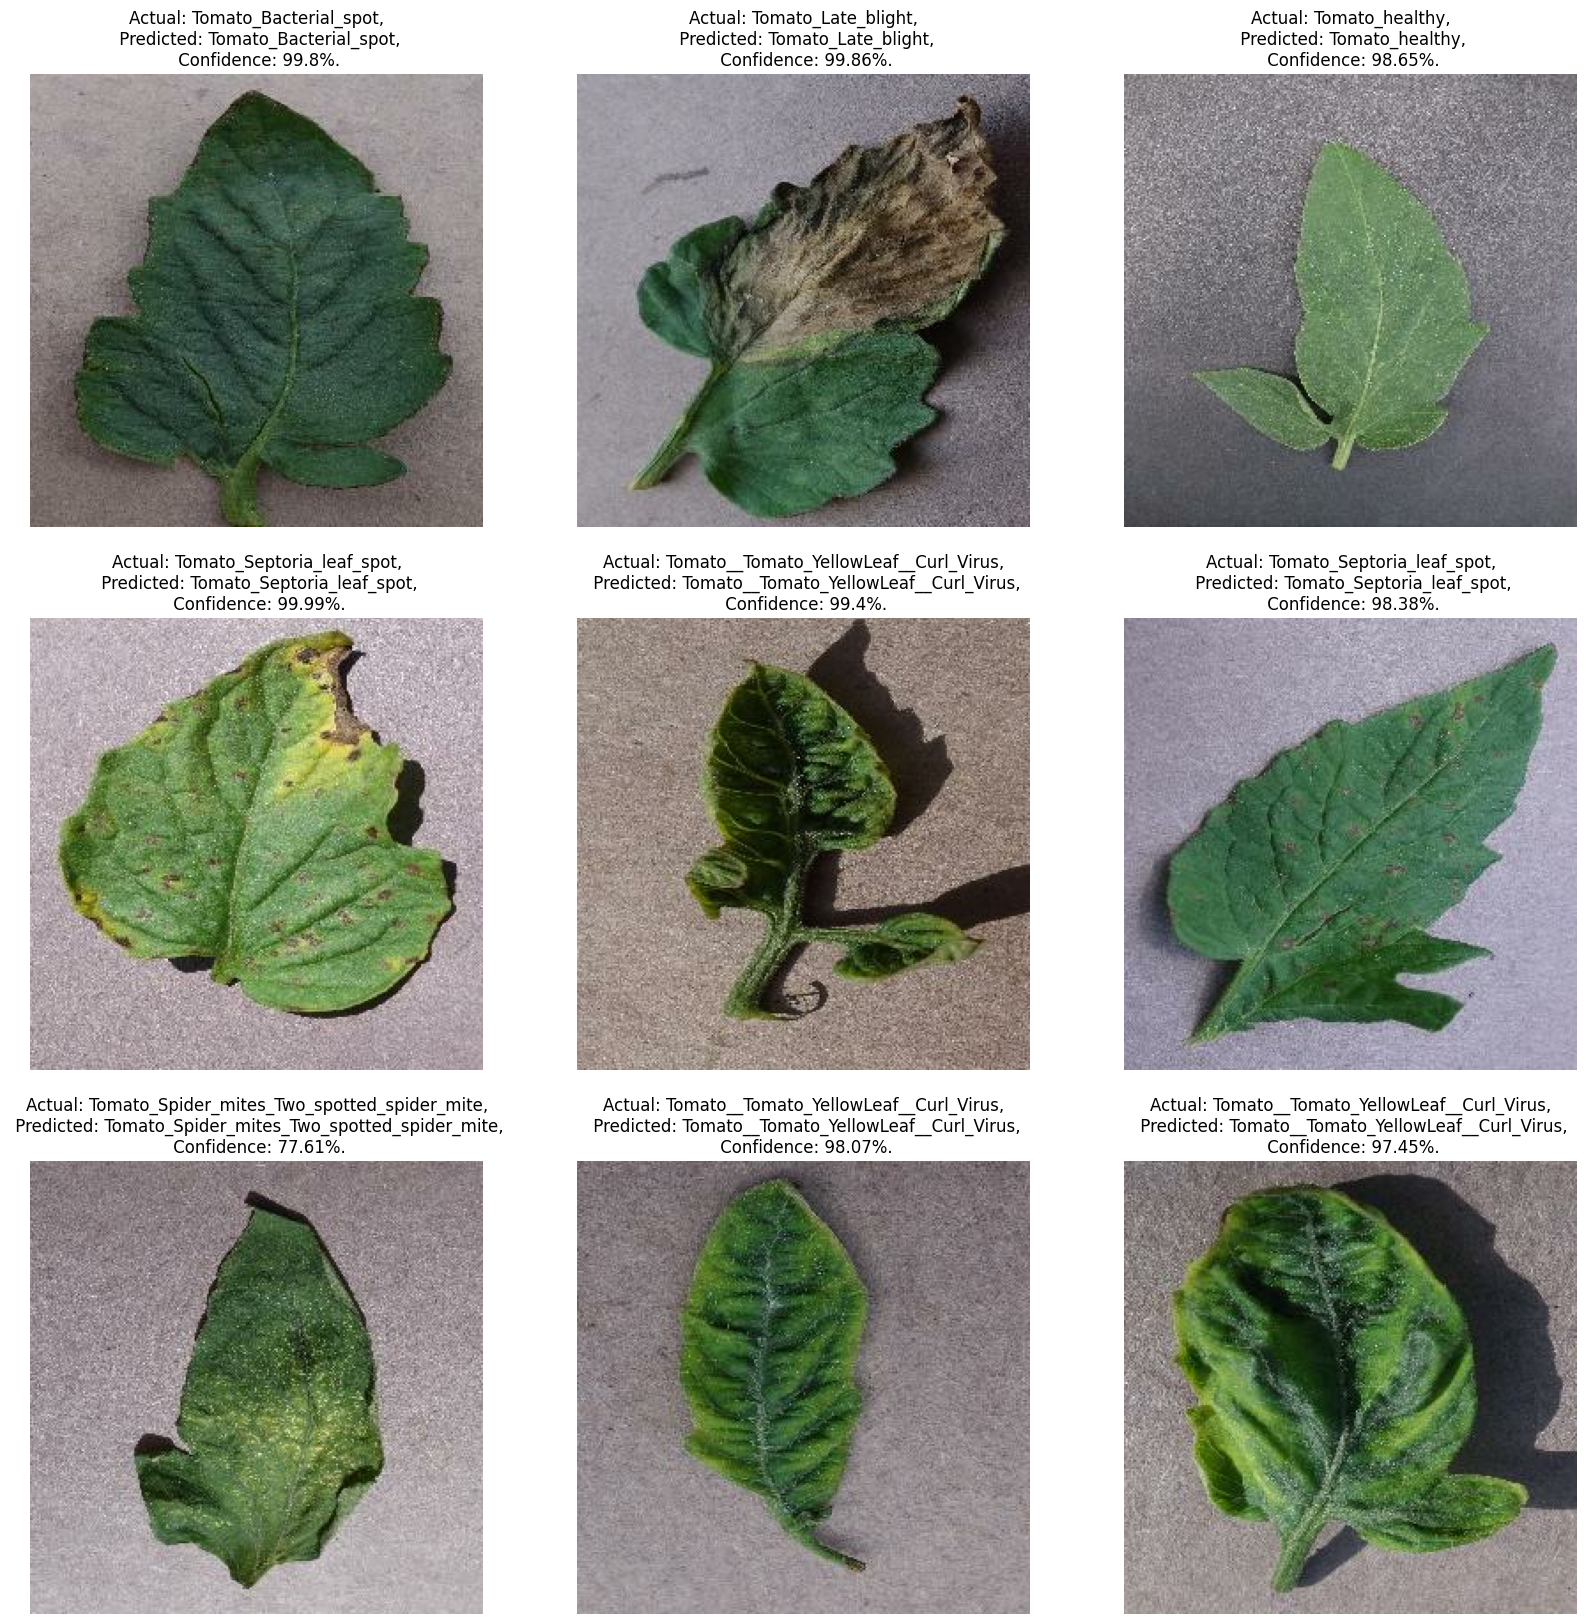

In [43]:
plt.figure(figsize=(20,20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax= plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%.")
        
        plt.axis("off")

In [44]:
import os
model_version = max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/1\assets


INFO:tensorflow:Assets written to: ../saved_models/1\assets
